## Advisory 
### If you have not yet begun the project 
Please do not use this workspace.  Use the AWS resources provided and the instructions from the [cloud computing lesson](https://classroom.udacity.com/nanodegrees/nd101/parts/b9c4c3c3-b524-427b-8832-9d0748f14a2e/modules/de12f7bf-d980-4998-ab91-0e411184c878/lessons/29df00d8-01c2-4995-92fa-a4afd020be90/concepts/80d2ed46-1bba-413e-891e-610259017251).
### If you have started on this workspace
Please consider downloading your Jupyter notebook and then following the instructions above on using AWS instead.  You can upload your current work to AWS through your GitHub account.  


As a reminder, the project can be found on the [deep learning GitHub page](https://github.com/udacity/deep-learning/tree/master/face_generation).
These warnings are given because the project frequently generates more data than the workspace can handle, causing loading problems and lost work.  Please use [the forums](https://discussions.udacity.com/c/nd101-part-5-GANs/nd101-generate-faces) if you have any questions on the project or its setup.


# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:13<00:00, 4.57KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

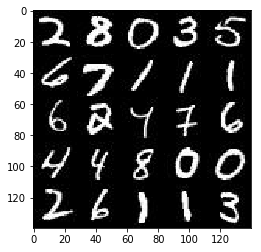

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

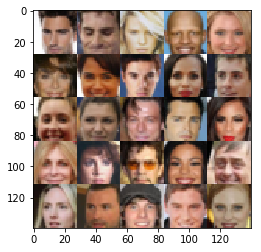

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.12.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [62]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = .2
    with tf.variable_scope('discriminator', reuse=reuse):    
        
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        # 28x28x64
               
        print(x1.get_shape())
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.layers.batch_normalization(x2, training=True)
        # 14x14x128
        
        print(x2.get_shape())
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=1, padding='same')
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.layers.batch_normalization(x3, training=True)
        # 14x14x256
        
        print(x3.get_shape())
        
        # Flatten it
        flat = tf.reshape(x3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

(?, 14, 14, 64)
(?, 7, 7, 128)
(?, 7, 7, 256)
(?, 14, 14, 64)
(?, 7, 7, 128)
(?, 7, 7, 256)
Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [69]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function

    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):  
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        # 7x7x512

        print(x1.get_shape())
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same') #,kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        # 14x14x256
        
        print(x2.get_shape())

        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same') #,kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        # 28x28x128 now
        
        print(x3.get_shape())

        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=1, padding='same') #,kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.maximum(alpha * x4, x4)
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        # 28x28x64 now
        
        print(x4.get_shape())
       
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=1, padding='same')
        # 28x28x3 now

        print(logits.get_shape())
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 5)
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 5)
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [64]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 4)
(?, 14, 14, 64)
(?, 7, 7, 128)
(?, 7, 7, 256)
(?, 14, 14, 64)
(?, 7, 7, 128)
(?, 7, 7, 256)
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [72]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [73]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [74]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    print_every = 10
    show_every = 100
    n_images = 9
    
    batch_count = 0
    
    batches, image_width, image_height, image_channels = (data_shape)

    input_real, input_z, model_learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
        
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
        
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_count += 1
                
                # rescale images to pass to D
                batch_images = batch_images * 2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})

                if batch_count % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if batch_count % show_every == 0:
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)
         
        # generate one last image
        print ("Done")
        show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 1)
(?, 14, 14, 64)
(?, 7, 7, 128)
(?, 7, 7, 256)
(?, 14, 14, 64)
(?, 7, 7, 128)
(?, 7, 7, 256)
Epoch 1/2... Discriminator Loss: 3.9242... Generator Loss: 0.0634
Epoch 1/2... Discriminator Loss: 1.6682... Generator Loss: 0.6634
Epoch 1/2... Discriminator Loss: 1.2518... Generator Loss: 0.7596
Epoch 1/2... Discriminator Loss: 0.8757... Generator Loss: 1.5828
Epoch 1/2... Discriminator Loss: 1.1153... Generator Loss: 1.1680
Epoch 1/2... Discriminator Loss: 3.1281... Generator Loss: 0.2780
Epoch 1/2... Discriminator Loss: 3.4477... Generator Loss: 0.1772
Epoch 1/2... Discriminator Loss: 4.8393... Generator Loss: 0.3203
Epoch 1/2... Discriminator Loss: 5.2191... Generator Loss: 0.0819
Epoch 1/2... Discriminator Loss: 6.5995... Generator Loss: 0.0557
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 1)


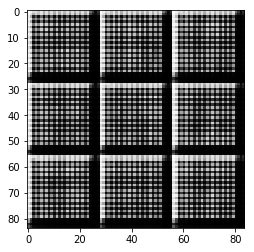

Epoch 1/2... Discriminator Loss: 3.9567... Generator Loss: 0.0828
Epoch 1/2... Discriminator Loss: 2.4003... Generator Loss: 0.4520
Epoch 1/2... Discriminator Loss: 2.3204... Generator Loss: 0.3789
Epoch 1/2... Discriminator Loss: 1.8288... Generator Loss: 0.6716
Epoch 1/2... Discriminator Loss: 1.4836... Generator Loss: 0.5968
Epoch 1/2... Discriminator Loss: 1.8022... Generator Loss: 0.7025
Epoch 1/2... Discriminator Loss: 1.6109... Generator Loss: 0.9908
Epoch 1/2... Discriminator Loss: 1.8031... Generator Loss: 0.4080
Epoch 1/2... Discriminator Loss: 1.6589... Generator Loss: 2.3932
Epoch 1/2... Discriminator Loss: 1.8536... Generator Loss: 0.3343
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 1)


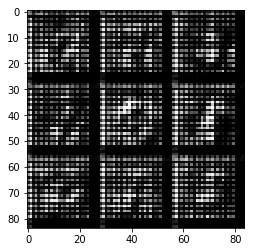

Epoch 1/2... Discriminator Loss: 1.4965... Generator Loss: 0.9222
Epoch 1/2... Discriminator Loss: 1.4315... Generator Loss: 0.6572
Epoch 1/2... Discriminator Loss: 1.7388... Generator Loss: 0.3811
Epoch 1/2... Discriminator Loss: 1.5090... Generator Loss: 0.5443
Epoch 1/2... Discriminator Loss: 1.6706... Generator Loss: 0.4673
Epoch 1/2... Discriminator Loss: 1.3872... Generator Loss: 1.2785
Epoch 1/2... Discriminator Loss: 1.7989... Generator Loss: 1.6678
Epoch 1/2... Discriminator Loss: 1.7781... Generator Loss: 0.3201
Epoch 1/2... Discriminator Loss: 1.6866... Generator Loss: 0.3708
Epoch 1/2... Discriminator Loss: 1.4682... Generator Loss: 1.3151
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 1)


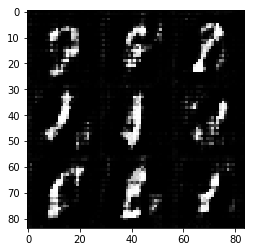

Epoch 1/2... Discriminator Loss: 1.4607... Generator Loss: 0.5153
Epoch 1/2... Discriminator Loss: 1.6282... Generator Loss: 0.5619
Epoch 1/2... Discriminator Loss: 1.8629... Generator Loss: 0.2931
Epoch 1/2... Discriminator Loss: 1.2611... Generator Loss: 0.7861
Epoch 1/2... Discriminator Loss: 1.6098... Generator Loss: 1.3626
Epoch 1/2... Discriminator Loss: 1.3356... Generator Loss: 0.9309
Epoch 1/2... Discriminator Loss: 1.2766... Generator Loss: 0.6891
Epoch 1/2... Discriminator Loss: 1.4366... Generator Loss: 0.5700
Epoch 1/2... Discriminator Loss: 1.4232... Generator Loss: 0.5388
Epoch 1/2... Discriminator Loss: 1.4453... Generator Loss: 1.3086
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 1)


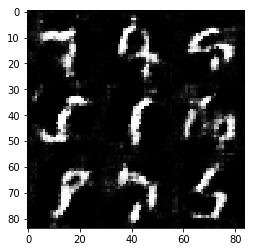

Epoch 1/2... Discriminator Loss: 1.6360... Generator Loss: 0.4260
Epoch 1/2... Discriminator Loss: 1.1629... Generator Loss: 0.8574
Epoch 1/2... Discriminator Loss: 1.5173... Generator Loss: 0.5055
Epoch 1/2... Discriminator Loss: 1.4475... Generator Loss: 0.5272
Epoch 1/2... Discriminator Loss: 1.6505... Generator Loss: 1.1193
Epoch 1/2... Discriminator Loss: 1.4548... Generator Loss: 0.5273
Epoch 1/2... Discriminator Loss: 1.2877... Generator Loss: 0.7481
Epoch 1/2... Discriminator Loss: 1.5021... Generator Loss: 0.5230
Epoch 1/2... Discriminator Loss: 1.2301... Generator Loss: 1.1322
Epoch 1/2... Discriminator Loss: 1.1534... Generator Loss: 1.1686
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 1)


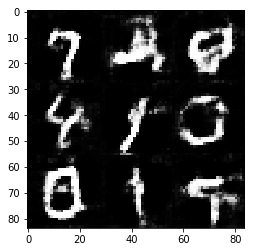

Epoch 1/2... Discriminator Loss: 1.2205... Generator Loss: 0.9308
Epoch 1/2... Discriminator Loss: 1.2526... Generator Loss: 1.3460
Epoch 1/2... Discriminator Loss: 1.1594... Generator Loss: 0.9839
Epoch 1/2... Discriminator Loss: 1.0452... Generator Loss: 1.3600
Epoch 1/2... Discriminator Loss: 1.5103... Generator Loss: 0.5439
Epoch 1/2... Discriminator Loss: 1.7301... Generator Loss: 0.3507
Epoch 1/2... Discriminator Loss: 1.2159... Generator Loss: 1.1532
Epoch 1/2... Discriminator Loss: 1.0914... Generator Loss: 0.8603
Epoch 1/2... Discriminator Loss: 1.4416... Generator Loss: 0.5378
Epoch 1/2... Discriminator Loss: 1.2274... Generator Loss: 0.6722
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 1)


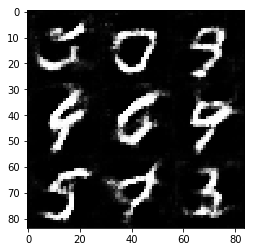

Epoch 1/2... Discriminator Loss: 1.1646... Generator Loss: 0.7976
Epoch 1/2... Discriminator Loss: 1.5651... Generator Loss: 0.4001
Epoch 1/2... Discriminator Loss: 1.2396... Generator Loss: 0.9413
Epoch 1/2... Discriminator Loss: 1.4025... Generator Loss: 0.7226
Epoch 1/2... Discriminator Loss: 1.3531... Generator Loss: 1.0987
Epoch 1/2... Discriminator Loss: 1.2413... Generator Loss: 0.8685
Epoch 1/2... Discriminator Loss: 1.2854... Generator Loss: 0.9633
Epoch 1/2... Discriminator Loss: 1.3561... Generator Loss: 0.6954
Epoch 1/2... Discriminator Loss: 1.3340... Generator Loss: 1.3185
Epoch 1/2... Discriminator Loss: 1.3370... Generator Loss: 0.6022
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 1)


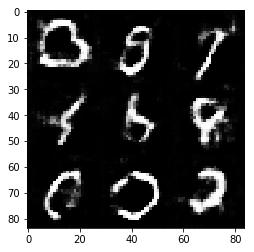

Epoch 1/2... Discriminator Loss: 1.3703... Generator Loss: 1.3045
Epoch 1/2... Discriminator Loss: 1.1360... Generator Loss: 0.8765
Epoch 1/2... Discriminator Loss: 1.2779... Generator Loss: 0.9980
Epoch 1/2... Discriminator Loss: 1.2256... Generator Loss: 0.6958
Epoch 1/2... Discriminator Loss: 1.1382... Generator Loss: 1.8502
Epoch 1/2... Discriminator Loss: 1.1821... Generator Loss: 0.9529
Epoch 1/2... Discriminator Loss: 1.3459... Generator Loss: 0.7206
Epoch 1/2... Discriminator Loss: 1.7053... Generator Loss: 2.1171
Epoch 1/2... Discriminator Loss: 1.2502... Generator Loss: 0.6587
Epoch 1/2... Discriminator Loss: 1.2547... Generator Loss: 0.7469
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 1)


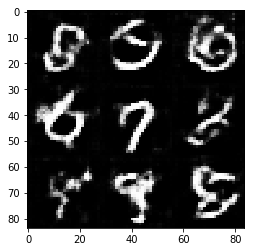

Epoch 1/2... Discriminator Loss: 1.1912... Generator Loss: 2.1792
Epoch 1/2... Discriminator Loss: 1.0420... Generator Loss: 1.2993
Epoch 1/2... Discriminator Loss: 1.2853... Generator Loss: 0.7852
Epoch 1/2... Discriminator Loss: 1.6443... Generator Loss: 0.3741
Epoch 1/2... Discriminator Loss: 1.2351... Generator Loss: 0.9461
Epoch 1/2... Discriminator Loss: 1.4739... Generator Loss: 0.5557
Epoch 1/2... Discriminator Loss: 1.1384... Generator Loss: 1.5114
Epoch 1/2... Discriminator Loss: 1.3606... Generator Loss: 0.5946
Epoch 1/2... Discriminator Loss: 1.2106... Generator Loss: 1.0792
Epoch 1/2... Discriminator Loss: 1.5258... Generator Loss: 0.4415
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 1)


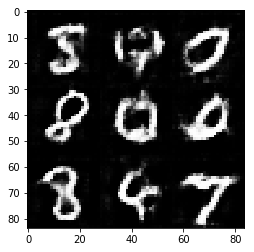

Epoch 1/2... Discriminator Loss: 1.7360... Generator Loss: 0.3654
Epoch 1/2... Discriminator Loss: 1.1281... Generator Loss: 0.8492
Epoch 1/2... Discriminator Loss: 1.3866... Generator Loss: 0.5284
Epoch 1/2... Discriminator Loss: 1.2640... Generator Loss: 0.6735
Epoch 1/2... Discriminator Loss: 1.1540... Generator Loss: 1.5327
Epoch 1/2... Discriminator Loss: 1.4549... Generator Loss: 0.4924
Epoch 1/2... Discriminator Loss: 1.1424... Generator Loss: 0.8851
Epoch 1/2... Discriminator Loss: 1.4686... Generator Loss: 0.4522
Epoch 1/2... Discriminator Loss: 1.2756... Generator Loss: 0.7436
Epoch 1/2... Discriminator Loss: 1.0996... Generator Loss: 1.0239
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 1)


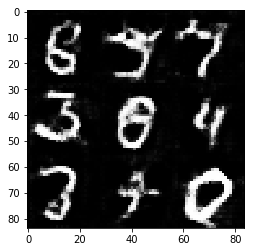

Epoch 1/2... Discriminator Loss: 1.2725... Generator Loss: 0.9746
Epoch 1/2... Discriminator Loss: 1.2650... Generator Loss: 1.0926
Epoch 1/2... Discriminator Loss: 1.0579... Generator Loss: 1.2702
Epoch 1/2... Discriminator Loss: 1.3851... Generator Loss: 0.5057
Epoch 1/2... Discriminator Loss: 1.0560... Generator Loss: 1.3628
Epoch 1/2... Discriminator Loss: 1.1272... Generator Loss: 1.0085
Epoch 1/2... Discriminator Loss: 1.1915... Generator Loss: 1.3583
Epoch 1/2... Discriminator Loss: 1.2236... Generator Loss: 0.9434
Epoch 1/2... Discriminator Loss: 1.1990... Generator Loss: 1.2853
Epoch 1/2... Discriminator Loss: 1.1332... Generator Loss: 1.1518
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 1)


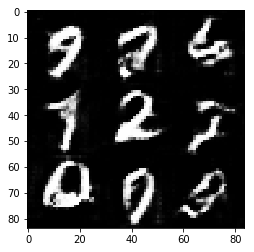

Epoch 1/2... Discriminator Loss: 1.5141... Generator Loss: 0.4905
Epoch 1/2... Discriminator Loss: 1.4908... Generator Loss: 0.4833
Epoch 1/2... Discriminator Loss: 1.6677... Generator Loss: 0.3977
Epoch 1/2... Discriminator Loss: 1.2044... Generator Loss: 0.8825
Epoch 1/2... Discriminator Loss: 1.3434... Generator Loss: 0.6602
Epoch 1/2... Discriminator Loss: 1.1755... Generator Loss: 1.0385
Epoch 1/2... Discriminator Loss: 1.6917... Generator Loss: 0.3604
Epoch 1/2... Discriminator Loss: 1.2630... Generator Loss: 0.8398
Epoch 1/2... Discriminator Loss: 1.3098... Generator Loss: 0.6238
Epoch 1/2... Discriminator Loss: 1.4659... Generator Loss: 0.4903
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 1)


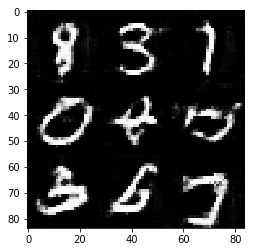

Epoch 1/2... Discriminator Loss: 1.1915... Generator Loss: 0.7646
Epoch 1/2... Discriminator Loss: 1.1041... Generator Loss: 1.2421
Epoch 1/2... Discriminator Loss: 1.5817... Generator Loss: 0.4069
Epoch 1/2... Discriminator Loss: 1.1981... Generator Loss: 1.4321
Epoch 1/2... Discriminator Loss: 1.2853... Generator Loss: 0.6980
Epoch 1/2... Discriminator Loss: 1.7183... Generator Loss: 0.3708
Epoch 1/2... Discriminator Loss: 1.2858... Generator Loss: 0.6266
Epoch 1/2... Discriminator Loss: 1.3409... Generator Loss: 0.6015
Epoch 1/2... Discriminator Loss: 1.3026... Generator Loss: 1.4552
Epoch 1/2... Discriminator Loss: 0.7926... Generator Loss: 1.6617
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 1)


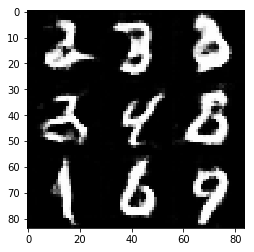

Epoch 1/2... Discriminator Loss: 1.4663... Generator Loss: 1.6562
Epoch 1/2... Discriminator Loss: 1.5274... Generator Loss: 0.4487
Epoch 1/2... Discriminator Loss: 1.2468... Generator Loss: 0.7209
Epoch 1/2... Discriminator Loss: 1.2125... Generator Loss: 0.8738
Epoch 1/2... Discriminator Loss: 1.2988... Generator Loss: 1.6171
Epoch 1/2... Discriminator Loss: 1.4055... Generator Loss: 1.2710
Epoch 1/2... Discriminator Loss: 1.9792... Generator Loss: 0.3159
Epoch 1/2... Discriminator Loss: 1.2164... Generator Loss: 1.2930
Epoch 1/2... Discriminator Loss: 1.5665... Generator Loss: 0.4413
Epoch 1/2... Discriminator Loss: 1.3635... Generator Loss: 0.6377
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 1)


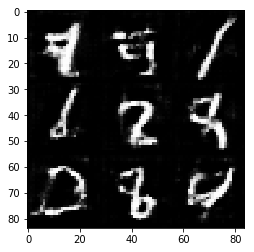

Epoch 1/2... Discriminator Loss: 1.4697... Generator Loss: 0.6468
Epoch 1/2... Discriminator Loss: 1.1530... Generator Loss: 0.6846
Epoch 1/2... Discriminator Loss: 1.3524... Generator Loss: 0.5643
Epoch 1/2... Discriminator Loss: 1.5778... Generator Loss: 0.5075
Epoch 1/2... Discriminator Loss: 1.3380... Generator Loss: 0.6069
Epoch 1/2... Discriminator Loss: 1.7304... Generator Loss: 0.3648
Epoch 1/2... Discriminator Loss: 1.0931... Generator Loss: 0.8193
Epoch 1/2... Discriminator Loss: 1.2252... Generator Loss: 1.1309
Epoch 1/2... Discriminator Loss: 1.3257... Generator Loss: 0.5914
Epoch 1/2... Discriminator Loss: 1.1268... Generator Loss: 1.2623
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 1)


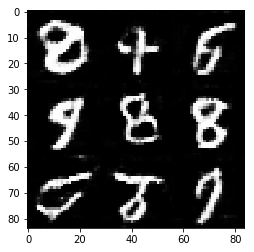

Epoch 1/2... Discriminator Loss: 1.5654... Generator Loss: 0.3881
Epoch 1/2... Discriminator Loss: 1.7954... Generator Loss: 0.3685
Epoch 1/2... Discriminator Loss: 1.2189... Generator Loss: 1.0707
Epoch 1/2... Discriminator Loss: 1.1294... Generator Loss: 0.7689
Epoch 1/2... Discriminator Loss: 1.0136... Generator Loss: 1.2951
Epoch 1/2... Discriminator Loss: 1.1117... Generator Loss: 1.1662
Epoch 1/2... Discriminator Loss: 1.8459... Generator Loss: 0.3619
Epoch 1/2... Discriminator Loss: 1.0331... Generator Loss: 0.9208
Epoch 1/2... Discriminator Loss: 1.1329... Generator Loss: 0.7264
Epoch 1/2... Discriminator Loss: 2.0084... Generator Loss: 0.2758
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 1)


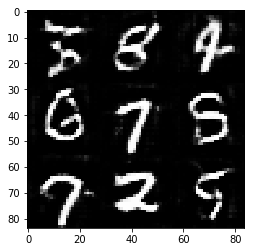

Epoch 1/2... Discriminator Loss: 1.5380... Generator Loss: 0.4907
Epoch 1/2... Discriminator Loss: 1.0553... Generator Loss: 1.2806
Epoch 1/2... Discriminator Loss: 0.9362... Generator Loss: 1.6212
Epoch 1/2... Discriminator Loss: 1.1323... Generator Loss: 0.8652
Epoch 1/2... Discriminator Loss: 1.0290... Generator Loss: 1.1466
Epoch 1/2... Discriminator Loss: 1.1551... Generator Loss: 1.6342
Epoch 1/2... Discriminator Loss: 1.0343... Generator Loss: 1.3435
Epoch 1/2... Discriminator Loss: 1.5476... Generator Loss: 0.4448
Epoch 1/2... Discriminator Loss: 1.0481... Generator Loss: 1.0115
Epoch 1/2... Discriminator Loss: 1.1206... Generator Loss: 2.0665
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 1)


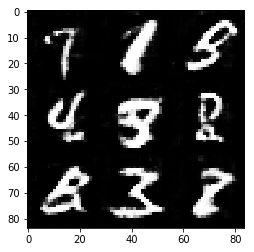

Epoch 1/2... Discriminator Loss: 1.1091... Generator Loss: 1.7479
Epoch 1/2... Discriminator Loss: 1.5330... Generator Loss: 0.4313
Epoch 1/2... Discriminator Loss: 0.9759... Generator Loss: 1.4099
Epoch 1/2... Discriminator Loss: 1.2493... Generator Loss: 0.7182
Epoch 1/2... Discriminator Loss: 1.3352... Generator Loss: 1.7204
Epoch 1/2... Discriminator Loss: 1.0847... Generator Loss: 1.5909
Epoch 1/2... Discriminator Loss: 1.1056... Generator Loss: 1.1103
Epoch 1/2... Discriminator Loss: 1.2724... Generator Loss: 0.8172
Epoch 1/2... Discriminator Loss: 1.5414... Generator Loss: 0.4824
Epoch 1/2... Discriminator Loss: 1.1820... Generator Loss: 0.7913
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 1)


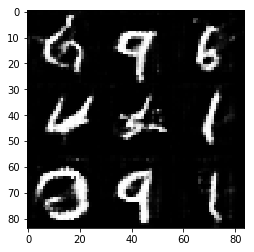

Epoch 1/2... Discriminator Loss: 0.9409... Generator Loss: 1.3000
Epoch 1/2... Discriminator Loss: 1.1746... Generator Loss: 1.3952
Epoch 1/2... Discriminator Loss: 1.4603... Generator Loss: 0.4783
Epoch 1/2... Discriminator Loss: 1.0045... Generator Loss: 1.0385
Epoch 1/2... Discriminator Loss: 0.9667... Generator Loss: 1.2038
Epoch 1/2... Discriminator Loss: 1.1016... Generator Loss: 0.8278
Epoch 1/2... Discriminator Loss: 1.0949... Generator Loss: 1.9703
Epoch 2/2... Discriminator Loss: 0.7621... Generator Loss: 1.4967
Epoch 2/2... Discriminator Loss: 1.0521... Generator Loss: 0.8931
Epoch 2/2... Discriminator Loss: 1.0230... Generator Loss: 1.3223
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 1)


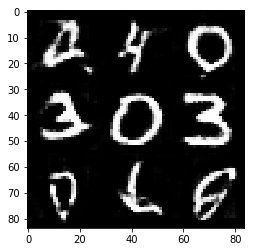

Epoch 2/2... Discriminator Loss: 1.1922... Generator Loss: 0.7395
Epoch 2/2... Discriminator Loss: 1.1230... Generator Loss: 2.0834
Epoch 2/2... Discriminator Loss: 1.1788... Generator Loss: 1.2288
Epoch 2/2... Discriminator Loss: 1.1380... Generator Loss: 0.8572
Epoch 2/2... Discriminator Loss: 1.0171... Generator Loss: 0.8630
Epoch 2/2... Discriminator Loss: 0.8508... Generator Loss: 1.4107
Epoch 2/2... Discriminator Loss: 2.1078... Generator Loss: 0.2901
Epoch 2/2... Discriminator Loss: 1.2971... Generator Loss: 0.5597
Epoch 2/2... Discriminator Loss: 1.1101... Generator Loss: 1.1448
Epoch 2/2... Discriminator Loss: 2.2186... Generator Loss: 0.2362
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 1)


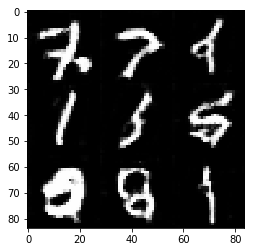

Epoch 2/2... Discriminator Loss: 1.1153... Generator Loss: 0.8354
Epoch 2/2... Discriminator Loss: 1.1260... Generator Loss: 1.4278
Epoch 2/2... Discriminator Loss: 1.3356... Generator Loss: 0.5472
Epoch 2/2... Discriminator Loss: 0.9797... Generator Loss: 1.1572
Epoch 2/2... Discriminator Loss: 1.5517... Generator Loss: 0.4514
Epoch 2/2... Discriminator Loss: 1.0724... Generator Loss: 0.9946
Epoch 2/2... Discriminator Loss: 1.1694... Generator Loss: 0.7659
Epoch 2/2... Discriminator Loss: 1.7481... Generator Loss: 0.3521
Epoch 2/2... Discriminator Loss: 1.2363... Generator Loss: 0.8592
Epoch 2/2... Discriminator Loss: 1.1962... Generator Loss: 0.9751
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 1)


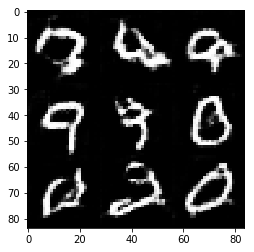

Epoch 2/2... Discriminator Loss: 1.0635... Generator Loss: 0.8207
Epoch 2/2... Discriminator Loss: 1.2036... Generator Loss: 0.7020
Epoch 2/2... Discriminator Loss: 1.3473... Generator Loss: 0.6135
Epoch 2/2... Discriminator Loss: 1.0464... Generator Loss: 1.4567
Epoch 2/2... Discriminator Loss: 1.3933... Generator Loss: 1.3937
Epoch 2/2... Discriminator Loss: 1.0922... Generator Loss: 0.8384
Epoch 2/2... Discriminator Loss: 0.9504... Generator Loss: 1.0109
Epoch 2/2... Discriminator Loss: 0.9242... Generator Loss: 1.4870
Epoch 2/2... Discriminator Loss: 1.3311... Generator Loss: 1.0378
Epoch 2/2... Discriminator Loss: 0.8548... Generator Loss: 1.5264
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 1)


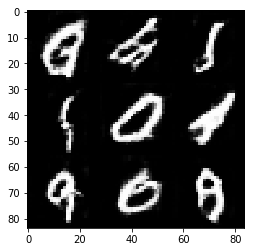

Epoch 2/2... Discriminator Loss: 0.8575... Generator Loss: 1.3956
Epoch 2/2... Discriminator Loss: 1.2366... Generator Loss: 0.6771
Epoch 2/2... Discriminator Loss: 1.1429... Generator Loss: 2.4669
Epoch 2/2... Discriminator Loss: 1.1086... Generator Loss: 1.1460
Epoch 2/2... Discriminator Loss: 0.9454... Generator Loss: 1.0248
Epoch 2/2... Discriminator Loss: 0.7859... Generator Loss: 1.1853
Epoch 2/2... Discriminator Loss: 1.0431... Generator Loss: 1.6241
Epoch 2/2... Discriminator Loss: 1.4992... Generator Loss: 0.5386
Epoch 2/2... Discriminator Loss: 1.1031... Generator Loss: 0.7646
Epoch 2/2... Discriminator Loss: 1.3486... Generator Loss: 0.5342
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 1)


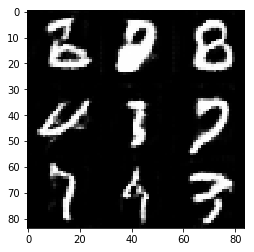

Epoch 2/2... Discriminator Loss: 1.5779... Generator Loss: 1.9052
Epoch 2/2... Discriminator Loss: 0.8636... Generator Loss: 1.4611
Epoch 2/2... Discriminator Loss: 1.1876... Generator Loss: 0.6748
Epoch 2/2... Discriminator Loss: 1.4581... Generator Loss: 0.4950
Epoch 2/2... Discriminator Loss: 1.2914... Generator Loss: 0.6561
Epoch 2/2... Discriminator Loss: 1.1107... Generator Loss: 0.7873
Epoch 2/2... Discriminator Loss: 0.9101... Generator Loss: 1.1949
Epoch 2/2... Discriminator Loss: 1.5812... Generator Loss: 1.8701
Epoch 2/2... Discriminator Loss: 1.0369... Generator Loss: 0.8492
Epoch 2/2... Discriminator Loss: 1.4669... Generator Loss: 0.5198
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 1)


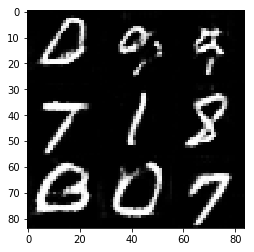

Epoch 2/2... Discriminator Loss: 1.1229... Generator Loss: 0.8854
Epoch 2/2... Discriminator Loss: 0.9723... Generator Loss: 0.8616
Epoch 2/2... Discriminator Loss: 0.8119... Generator Loss: 1.9072
Epoch 2/2... Discriminator Loss: 2.2655... Generator Loss: 0.2353
Epoch 2/2... Discriminator Loss: 1.0080... Generator Loss: 0.9192
Epoch 2/2... Discriminator Loss: 2.1730... Generator Loss: 2.6624
Epoch 2/2... Discriminator Loss: 1.1727... Generator Loss: 2.2457


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)
(?, 14, 14, 64)
(?, 7, 7, 128)
(?, 4, 4, 256)
(?, 14, 14, 64)
(?, 7, 7, 128)
(?, 4, 4, 256)
Epoch 1/1... Discriminator Loss: 7.9712... Generator Loss: 0.0006
Epoch 1/1... Discriminator Loss: 5.8212... Generator Loss: 0.0073
Epoch 1/1... Discriminator Loss: 4.4962... Generator Loss: 0.0441
Epoch 1/1... Discriminator Loss: 3.7154... Generator Loss: 0.0576
Epoch 1/1... Discriminator Loss: 3.2956... Generator Loss: 0.0772
Epoch 1/1... Discriminator Loss: 3.0768... Generator Loss: 0.1047
Epoch 1/1... Discriminator Loss: 2.4579... Generator Loss: 0.2083
Epoch 1/1... Discriminator Loss: 2.5009... Generator Loss: 0.2350
Epoch 1/1... Discriminator Loss: 1.2622... Generator Loss: 0.6853
Epoch 1/1... Discriminator Loss: 3.6085... Generator Loss: 0.0516
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


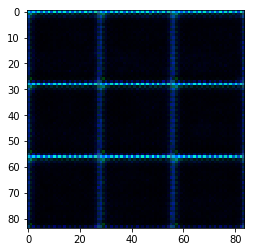

Epoch 1/1... Discriminator Loss: 1.9378... Generator Loss: 0.3591
Epoch 1/1... Discriminator Loss: 1.5557... Generator Loss: 0.5960
Epoch 1/1... Discriminator Loss: 1.2780... Generator Loss: 0.7749
Epoch 1/1... Discriminator Loss: 0.6665... Generator Loss: 2.2070
Epoch 1/1... Discriminator Loss: 1.9916... Generator Loss: 1.8025
Epoch 1/1... Discriminator Loss: 1.7022... Generator Loss: 0.5449
Epoch 1/1... Discriminator Loss: 1.2038... Generator Loss: 0.8700
Epoch 1/1... Discriminator Loss: 0.6862... Generator Loss: 1.7121
Epoch 1/1... Discriminator Loss: 1.4515... Generator Loss: 0.5694
Epoch 1/1... Discriminator Loss: 0.9216... Generator Loss: 3.9725
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


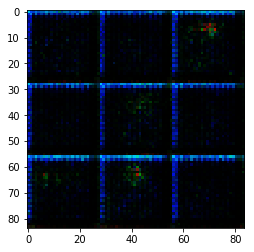

Epoch 1/1... Discriminator Loss: 0.6536... Generator Loss: 1.9219
Epoch 1/1... Discriminator Loss: 0.8461... Generator Loss: 1.3217
Epoch 1/1... Discriminator Loss: 0.8838... Generator Loss: 1.1001
Epoch 1/1... Discriminator Loss: 0.5990... Generator Loss: 2.2457
Epoch 1/1... Discriminator Loss: 1.0182... Generator Loss: 3.3791
Epoch 1/1... Discriminator Loss: 2.5108... Generator Loss: 0.1786
Epoch 1/1... Discriminator Loss: 1.3607... Generator Loss: 0.5580
Epoch 1/1... Discriminator Loss: 0.8409... Generator Loss: 1.9924
Epoch 1/1... Discriminator Loss: 1.0804... Generator Loss: 0.7233
Epoch 1/1... Discriminator Loss: 2.2085... Generator Loss: 0.2364
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


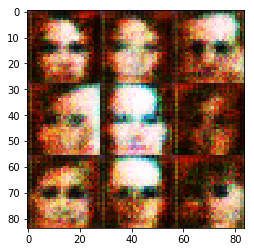

Epoch 1/1... Discriminator Loss: 0.7290... Generator Loss: 1.3312
Epoch 1/1... Discriminator Loss: 1.1104... Generator Loss: 0.7606
Epoch 1/1... Discriminator Loss: 1.5817... Generator Loss: 0.4364
Epoch 1/1... Discriminator Loss: 0.5986... Generator Loss: 2.0961
Epoch 1/1... Discriminator Loss: 1.1776... Generator Loss: 0.7706
Epoch 1/1... Discriminator Loss: 0.7354... Generator Loss: 2.3429
Epoch 1/1... Discriminator Loss: 0.6735... Generator Loss: 1.7556
Epoch 1/1... Discriminator Loss: 1.1695... Generator Loss: 0.7366
Epoch 1/1... Discriminator Loss: 0.8080... Generator Loss: 1.6809
Epoch 1/1... Discriminator Loss: 0.9868... Generator Loss: 1.1020
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


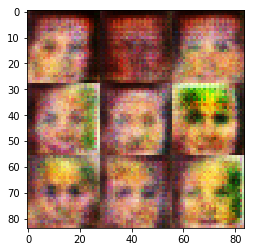

Epoch 1/1... Discriminator Loss: 2.2071... Generator Loss: 0.2500
Epoch 1/1... Discriminator Loss: 1.0119... Generator Loss: 1.1409
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.6320
Epoch 1/1... Discriminator Loss: 1.8695... Generator Loss: 0.4080
Epoch 1/1... Discriminator Loss: 1.2445... Generator Loss: 0.8727
Epoch 1/1... Discriminator Loss: 1.3515... Generator Loss: 0.8557
Epoch 1/1... Discriminator Loss: 1.2368... Generator Loss: 0.7583
Epoch 1/1... Discriminator Loss: 1.3475... Generator Loss: 0.6431
Epoch 1/1... Discriminator Loss: 0.9387... Generator Loss: 2.4802
Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 1.0238
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


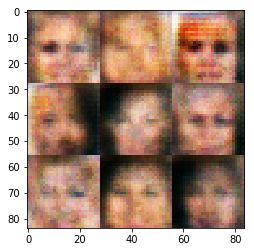

Epoch 1/1... Discriminator Loss: 1.1460... Generator Loss: 2.4932
Epoch 1/1... Discriminator Loss: 0.9577... Generator Loss: 1.0124
Epoch 1/1... Discriminator Loss: 1.2553... Generator Loss: 0.6171
Epoch 1/1... Discriminator Loss: 1.1110... Generator Loss: 1.1083
Epoch 1/1... Discriminator Loss: 1.1760... Generator Loss: 1.6923
Epoch 1/1... Discriminator Loss: 1.0481... Generator Loss: 0.9636
Epoch 1/1... Discriminator Loss: 1.2086... Generator Loss: 2.0497
Epoch 1/1... Discriminator Loss: 0.8659... Generator Loss: 1.2996
Epoch 1/1... Discriminator Loss: 1.1882... Generator Loss: 1.8342
Epoch 1/1... Discriminator Loss: 1.7310... Generator Loss: 0.3918
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


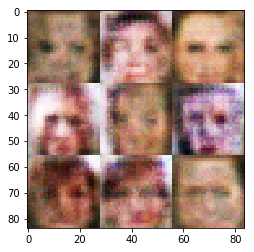

Epoch 1/1... Discriminator Loss: 1.7516... Generator Loss: 0.3771
Epoch 1/1... Discriminator Loss: 1.4903... Generator Loss: 0.5630
Epoch 1/1... Discriminator Loss: 1.3015... Generator Loss: 0.7912
Epoch 1/1... Discriminator Loss: 0.8090... Generator Loss: 1.8079
Epoch 1/1... Discriminator Loss: 1.2648... Generator Loss: 0.7314
Epoch 1/1... Discriminator Loss: 1.7784... Generator Loss: 0.4008
Epoch 1/1... Discriminator Loss: 2.0299... Generator Loss: 0.2583
Epoch 1/1... Discriminator Loss: 1.5917... Generator Loss: 0.4461
Epoch 1/1... Discriminator Loss: 2.2173... Generator Loss: 2.4822
Epoch 1/1... Discriminator Loss: 1.1859... Generator Loss: 1.1513
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


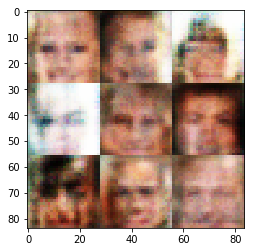

Epoch 1/1... Discriminator Loss: 1.6828... Generator Loss: 0.4503
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.6449
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 1.4871
Epoch 1/1... Discriminator Loss: 1.4748... Generator Loss: 0.7246
Epoch 1/1... Discriminator Loss: 1.3377... Generator Loss: 1.1220
Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 0.5672
Epoch 1/1... Discriminator Loss: 1.1874... Generator Loss: 1.0678
Epoch 1/1... Discriminator Loss: 1.7157... Generator Loss: 0.4202
Epoch 1/1... Discriminator Loss: 1.6078... Generator Loss: 0.5075
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 0.6171
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


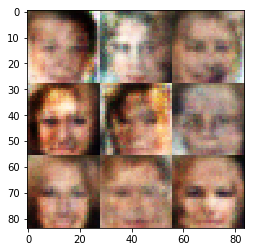

Epoch 1/1... Discriminator Loss: 1.4514... Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 1.5041... Generator Loss: 1.0192
Epoch 1/1... Discriminator Loss: 1.3028... Generator Loss: 0.6611
Epoch 1/1... Discriminator Loss: 1.6358... Generator Loss: 0.5384
Epoch 1/1... Discriminator Loss: 1.3381... Generator Loss: 0.6837
Epoch 1/1... Discriminator Loss: 1.7151... Generator Loss: 0.3984
Epoch 1/1... Discriminator Loss: 1.5228... Generator Loss: 0.5569
Epoch 1/1... Discriminator Loss: 1.4378... Generator Loss: 0.5612
Epoch 1/1... Discriminator Loss: 1.4880... Generator Loss: 0.5298
Epoch 1/1... Discriminator Loss: 1.6472... Generator Loss: 0.4051
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


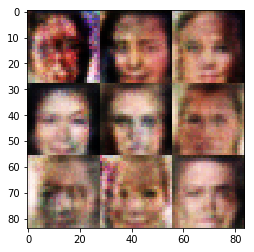

Epoch 1/1... Discriminator Loss: 1.3373... Generator Loss: 0.6521
Epoch 1/1... Discriminator Loss: 1.6091... Generator Loss: 0.4176
Epoch 1/1... Discriminator Loss: 1.3154... Generator Loss: 1.1348
Epoch 1/1... Discriminator Loss: 1.5180... Generator Loss: 0.6426
Epoch 1/1... Discriminator Loss: 1.4412... Generator Loss: 0.6512
Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 1.2475
Epoch 1/1... Discriminator Loss: 1.5964... Generator Loss: 0.4600
Epoch 1/1... Discriminator Loss: 1.5582... Generator Loss: 1.2766
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.5673
Epoch 1/1... Discriminator Loss: 1.5206... Generator Loss: 0.5601
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


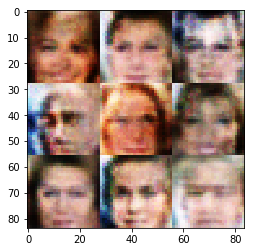

Epoch 1/1... Discriminator Loss: 1.2496... Generator Loss: 0.7375
Epoch 1/1... Discriminator Loss: 1.6095... Generator Loss: 0.4475
Epoch 1/1... Discriminator Loss: 1.2236... Generator Loss: 0.9370
Epoch 1/1... Discriminator Loss: 1.2968... Generator Loss: 0.7645
Epoch 1/1... Discriminator Loss: 1.4269... Generator Loss: 0.5232
Epoch 1/1... Discriminator Loss: 1.2450... Generator Loss: 0.6831
Epoch 1/1... Discriminator Loss: 1.4771... Generator Loss: 0.5001
Epoch 1/1... Discriminator Loss: 1.6040... Generator Loss: 0.4030
Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.4772
Epoch 1/1... Discriminator Loss: 1.5359... Generator Loss: 0.4472
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


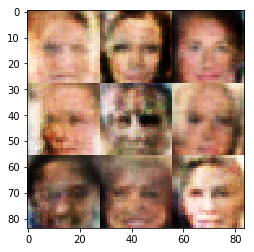

Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.5482
Epoch 1/1... Discriminator Loss: 1.5520... Generator Loss: 0.4402
Epoch 1/1... Discriminator Loss: 1.3381... Generator Loss: 0.6766
Epoch 1/1... Discriminator Loss: 1.4400... Generator Loss: 0.5592
Epoch 1/1... Discriminator Loss: 1.4618... Generator Loss: 0.8400
Epoch 1/1... Discriminator Loss: 1.3487... Generator Loss: 0.5801
Epoch 1/1... Discriminator Loss: 1.4895... Generator Loss: 0.4913
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.6802
Epoch 1/1... Discriminator Loss: 1.5104... Generator Loss: 0.4773
Epoch 1/1... Discriminator Loss: 1.3082... Generator Loss: 0.6584
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


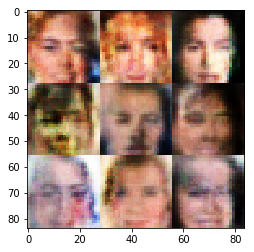

Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.5386
Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 0.5387
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.6872
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.7654
Epoch 1/1... Discriminator Loss: 1.6625... Generator Loss: 0.3950
Epoch 1/1... Discriminator Loss: 1.3479... Generator Loss: 0.6976
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.5499
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.5863
Epoch 1/1... Discriminator Loss: 1.2574... Generator Loss: 0.6111
Epoch 1/1... Discriminator Loss: 1.3108... Generator Loss: 0.9490
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


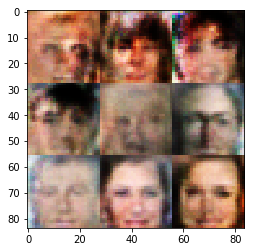

Epoch 1/1... Discriminator Loss: 1.7349... Generator Loss: 0.4073
Epoch 1/1... Discriminator Loss: 1.2880... Generator Loss: 0.9283
Epoch 1/1... Discriminator Loss: 1.5220... Generator Loss: 0.5900
Epoch 1/1... Discriminator Loss: 1.3502... Generator Loss: 0.6195
Epoch 1/1... Discriminator Loss: 1.1875... Generator Loss: 0.9792
Epoch 1/1... Discriminator Loss: 1.3055... Generator Loss: 0.7003
Epoch 1/1... Discriminator Loss: 1.1639... Generator Loss: 0.9149
Epoch 1/1... Discriminator Loss: 1.6038... Generator Loss: 0.4430
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.5681
Epoch 1/1... Discriminator Loss: 1.5932... Generator Loss: 0.6932
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


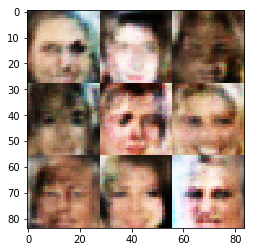

Epoch 1/1... Discriminator Loss: 1.2789... Generator Loss: 0.6951
Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 0.8347
Epoch 1/1... Discriminator Loss: 1.5957... Generator Loss: 0.4137
Epoch 1/1... Discriminator Loss: 1.3239... Generator Loss: 0.9857
Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.6074
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.5238
Epoch 1/1... Discriminator Loss: 1.3231... Generator Loss: 0.6135
Epoch 1/1... Discriminator Loss: 1.2516... Generator Loss: 0.6559
Epoch 1/1... Discriminator Loss: 1.3099... Generator Loss: 0.6025
Epoch 1/1... Discriminator Loss: 1.5053... Generator Loss: 0.4688
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


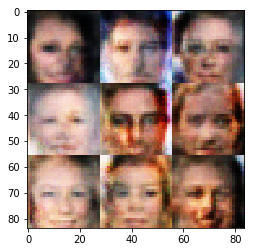

Epoch 1/1... Discriminator Loss: 1.1091... Generator Loss: 0.8573
Epoch 1/1... Discriminator Loss: 1.1053... Generator Loss: 0.9499
Epoch 1/1... Discriminator Loss: 1.5602... Generator Loss: 0.6125
Epoch 1/1... Discriminator Loss: 1.2144... Generator Loss: 0.6775
Epoch 1/1... Discriminator Loss: 1.4809... Generator Loss: 0.5312
Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.5704
Epoch 1/1... Discriminator Loss: 1.3284... Generator Loss: 0.6727
Epoch 1/1... Discriminator Loss: 1.5607... Generator Loss: 0.4003
Epoch 1/1... Discriminator Loss: 1.4713... Generator Loss: 0.5396
Epoch 1/1... Discriminator Loss: 1.4712... Generator Loss: 0.5289
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


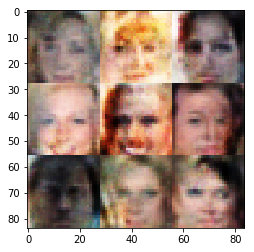

Epoch 1/1... Discriminator Loss: 1.3118... Generator Loss: 0.6068
Epoch 1/1... Discriminator Loss: 1.4569... Generator Loss: 0.4268
Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 0.5601
Epoch 1/1... Discriminator Loss: 1.7808... Generator Loss: 0.3369
Epoch 1/1... Discriminator Loss: 1.2605... Generator Loss: 0.8144
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.6045
Epoch 1/1... Discriminator Loss: 1.6217... Generator Loss: 0.4104
Epoch 1/1... Discriminator Loss: 1.5152... Generator Loss: 0.4590
Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 0.6754
Epoch 1/1... Discriminator Loss: 1.2549... Generator Loss: 0.6734
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


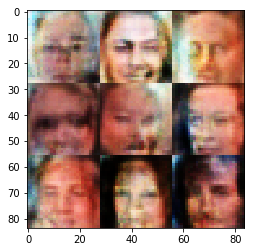

Epoch 1/1... Discriminator Loss: 1.3274... Generator Loss: 0.7540
Epoch 1/1... Discriminator Loss: 1.7231... Generator Loss: 0.3907
Epoch 1/1... Discriminator Loss: 1.0691... Generator Loss: 1.0142
Epoch 1/1... Discriminator Loss: 1.3701... Generator Loss: 0.5876
Epoch 1/1... Discriminator Loss: 1.4549... Generator Loss: 0.5170
Epoch 1/1... Discriminator Loss: 1.4525... Generator Loss: 0.5497
Epoch 1/1... Discriminator Loss: 1.7907... Generator Loss: 0.3062
Epoch 1/1... Discriminator Loss: 1.3349... Generator Loss: 0.6266
Epoch 1/1... Discriminator Loss: 1.3117... Generator Loss: 0.7842
Epoch 1/1... Discriminator Loss: 1.4632... Generator Loss: 0.6239
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


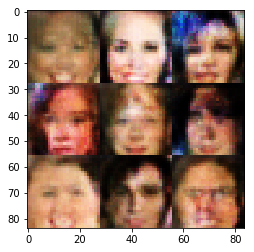

Epoch 1/1... Discriminator Loss: 1.5600... Generator Loss: 0.4107
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.5616
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.7979
Epoch 1/1... Discriminator Loss: 1.7301... Generator Loss: 0.3690
Epoch 1/1... Discriminator Loss: 1.7591... Generator Loss: 0.3380
Epoch 1/1... Discriminator Loss: 1.7094... Generator Loss: 0.4112
Epoch 1/1... Discriminator Loss: 1.5216... Generator Loss: 0.4515
Epoch 1/1... Discriminator Loss: 1.2628... Generator Loss: 0.6460
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.5458
Epoch 1/1... Discriminator Loss: 1.7066... Generator Loss: 0.4035
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


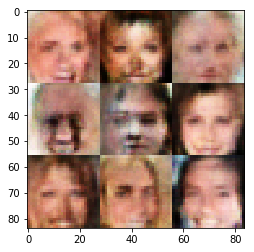

Epoch 1/1... Discriminator Loss: 2.0930... Generator Loss: 0.2323
Epoch 1/1... Discriminator Loss: 0.9789... Generator Loss: 0.9436
Epoch 1/1... Discriminator Loss: 0.8588... Generator Loss: 1.3412
Epoch 1/1... Discriminator Loss: 1.0381... Generator Loss: 0.8300
Epoch 1/1... Discriminator Loss: 0.6517... Generator Loss: 3.3769
Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.8639
Epoch 1/1... Discriminator Loss: 0.8529... Generator Loss: 1.1522
Epoch 1/1... Discriminator Loss: 1.4495... Generator Loss: 0.5221
Epoch 1/1... Discriminator Loss: 0.8997... Generator Loss: 1.0738
Epoch 1/1... Discriminator Loss: 1.8685... Generator Loss: 0.2979
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


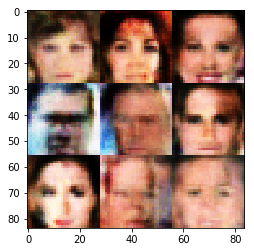

Epoch 1/1... Discriminator Loss: 1.7900... Generator Loss: 0.3079
Epoch 1/1... Discriminator Loss: 1.7543... Generator Loss: 0.3644
Epoch 1/1... Discriminator Loss: 0.8302... Generator Loss: 1.4251
Epoch 1/1... Discriminator Loss: 0.8197... Generator Loss: 1.4230
Epoch 1/1... Discriminator Loss: 0.9815... Generator Loss: 0.8790
Epoch 1/1... Discriminator Loss: 1.0770... Generator Loss: 0.7886
Epoch 1/1... Discriminator Loss: 1.9506... Generator Loss: 0.2643
Epoch 1/1... Discriminator Loss: 1.4366... Generator Loss: 0.5965
Epoch 1/1... Discriminator Loss: 1.1975... Generator Loss: 1.0584
Epoch 1/1... Discriminator Loss: 1.1529... Generator Loss: 0.7266
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


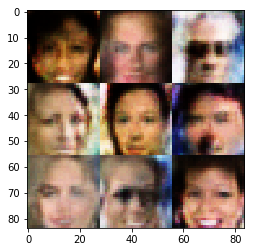

Epoch 1/1... Discriminator Loss: 1.0784... Generator Loss: 0.8770
Epoch 1/1... Discriminator Loss: 1.0134... Generator Loss: 0.9265
Epoch 1/1... Discriminator Loss: 2.1670... Generator Loss: 0.2151
Epoch 1/1... Discriminator Loss: 0.6254... Generator Loss: 1.9242
Epoch 1/1... Discriminator Loss: 0.7688... Generator Loss: 1.5015
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.5512
Epoch 1/1... Discriminator Loss: 1.2238... Generator Loss: 0.7892
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.5048
Epoch 1/1... Discriminator Loss: 1.7561... Generator Loss: 0.3550
Epoch 1/1... Discriminator Loss: 1.0899... Generator Loss: 0.7370
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


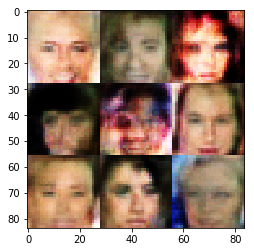

Epoch 1/1... Discriminator Loss: 1.3336... Generator Loss: 0.6531
Epoch 1/1... Discriminator Loss: 1.0780... Generator Loss: 1.4159
Epoch 1/1... Discriminator Loss: 0.9109... Generator Loss: 1.7996
Epoch 1/1... Discriminator Loss: 0.8742... Generator Loss: 1.2923
Epoch 1/1... Discriminator Loss: 1.0412... Generator Loss: 1.0323
Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 0.6793
Epoch 1/1... Discriminator Loss: 1.5382... Generator Loss: 0.4779
Epoch 1/1... Discriminator Loss: 1.0389... Generator Loss: 0.8877
Epoch 1/1... Discriminator Loss: 0.7499... Generator Loss: 1.5596
Epoch 1/1... Discriminator Loss: 0.9990... Generator Loss: 0.8127
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


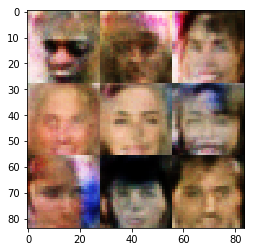

Epoch 1/1... Discriminator Loss: 1.4587... Generator Loss: 0.4638
Epoch 1/1... Discriminator Loss: 1.2160... Generator Loss: 0.8044
Epoch 1/1... Discriminator Loss: 1.4918... Generator Loss: 0.4771
Epoch 1/1... Discriminator Loss: 1.2739... Generator Loss: 0.6210
Epoch 1/1... Discriminator Loss: 1.6156... Generator Loss: 0.4466
Epoch 1/1... Discriminator Loss: 0.9870... Generator Loss: 1.0117
Epoch 1/1... Discriminator Loss: 1.2657... Generator Loss: 0.7017
Epoch 1/1... Discriminator Loss: 2.1396... Generator Loss: 0.2439
Epoch 1/1... Discriminator Loss: 1.1264... Generator Loss: 0.7722
Epoch 1/1... Discriminator Loss: 1.3378... Generator Loss: 0.8473
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


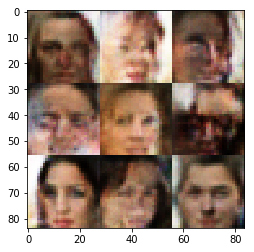

Epoch 1/1... Discriminator Loss: 1.2895... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.2159... Generator Loss: 0.8154
Epoch 1/1... Discriminator Loss: 1.3173... Generator Loss: 0.6666
Epoch 1/1... Discriminator Loss: 1.9189... Generator Loss: 0.3090
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.5351
Epoch 1/1... Discriminator Loss: 1.9920... Generator Loss: 0.2832
Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.6846
Epoch 1/1... Discriminator Loss: 1.0396... Generator Loss: 0.8993
Epoch 1/1... Discriminator Loss: 1.3256... Generator Loss: 0.6843
Epoch 1/1... Discriminator Loss: 1.8057... Generator Loss: 0.3807
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


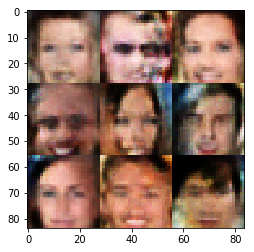

Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.5301
Epoch 1/1... Discriminator Loss: 1.0401... Generator Loss: 0.8582
Epoch 1/1... Discriminator Loss: 1.2784... Generator Loss: 0.6463
Epoch 1/1... Discriminator Loss: 0.9526... Generator Loss: 1.0437
Epoch 1/1... Discriminator Loss: 1.5919... Generator Loss: 0.4496
Epoch 1/1... Discriminator Loss: 1.1947... Generator Loss: 0.9012
Epoch 1/1... Discriminator Loss: 1.6480... Generator Loss: 0.3672
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.5627
Epoch 1/1... Discriminator Loss: 1.2906... Generator Loss: 0.6505
Epoch 1/1... Discriminator Loss: 1.5778... Generator Loss: 0.4066
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


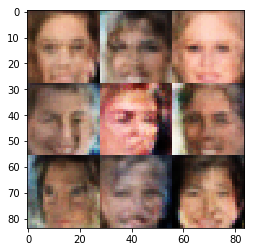

Epoch 1/1... Discriminator Loss: 1.4909... Generator Loss: 0.5054
Epoch 1/1... Discriminator Loss: 1.6232... Generator Loss: 0.4284
Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.6380
Epoch 1/1... Discriminator Loss: 1.7628... Generator Loss: 0.3685
Epoch 1/1... Discriminator Loss: 1.4803... Generator Loss: 0.4981
Epoch 1/1... Discriminator Loss: 1.0446... Generator Loss: 0.8611
Epoch 1/1... Discriminator Loss: 1.7288... Generator Loss: 0.3699
Epoch 1/1... Discriminator Loss: 1.3196... Generator Loss: 0.6745
Epoch 1/1... Discriminator Loss: 1.3374... Generator Loss: 0.5642
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.6023
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


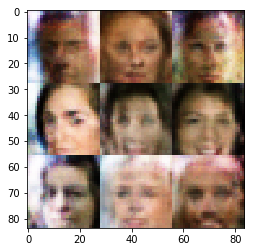

Epoch 1/1... Discriminator Loss: 1.5866... Generator Loss: 0.4447
Epoch 1/1... Discriminator Loss: 1.5773... Generator Loss: 0.3953
Epoch 1/1... Discriminator Loss: 1.6809... Generator Loss: 0.7151
Epoch 1/1... Discriminator Loss: 1.4712... Generator Loss: 0.7196
Epoch 1/1... Discriminator Loss: 1.5545... Generator Loss: 0.4797
Epoch 1/1... Discriminator Loss: 1.5691... Generator Loss: 0.5789
Epoch 1/1... Discriminator Loss: 1.0914... Generator Loss: 0.7526
Epoch 1/1... Discriminator Loss: 1.2932... Generator Loss: 0.7179
Epoch 1/1... Discriminator Loss: 1.1293... Generator Loss: 1.0900
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.7738
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


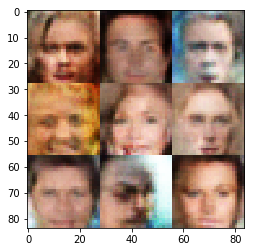

Epoch 1/1... Discriminator Loss: 1.3479... Generator Loss: 0.8476
Epoch 1/1... Discriminator Loss: 1.4863... Generator Loss: 0.6189
Epoch 1/1... Discriminator Loss: 1.7069... Generator Loss: 0.3415
Epoch 1/1... Discriminator Loss: 1.5496... Generator Loss: 0.4775
Epoch 1/1... Discriminator Loss: 1.1048... Generator Loss: 0.9221
Epoch 1/1... Discriminator Loss: 1.4538... Generator Loss: 0.5368
Epoch 1/1... Discriminator Loss: 1.2653... Generator Loss: 0.8896
Epoch 1/1... Discriminator Loss: 1.5544... Generator Loss: 0.5911
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.6241
Epoch 1/1... Discriminator Loss: 1.5689... Generator Loss: 0.4740
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


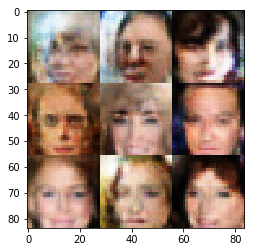

Epoch 1/1... Discriminator Loss: 1.5815... Generator Loss: 0.5051
Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.5201
Epoch 1/1... Discriminator Loss: 1.4542... Generator Loss: 0.5279
Epoch 1/1... Discriminator Loss: 1.4794... Generator Loss: 0.5731
Epoch 1/1... Discriminator Loss: 1.6144... Generator Loss: 0.4279
Epoch 1/1... Discriminator Loss: 1.4558... Generator Loss: 0.5753
Epoch 1/1... Discriminator Loss: 1.6268... Generator Loss: 0.4566
Epoch 1/1... Discriminator Loss: 1.6173... Generator Loss: 0.4288
Epoch 1/1... Discriminator Loss: 1.5574... Generator Loss: 0.4624
Epoch 1/1... Discriminator Loss: 1.6418... Generator Loss: 0.4036
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


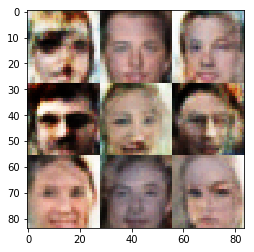

Epoch 1/1... Discriminator Loss: 1.6821... Generator Loss: 0.3976
Epoch 1/1... Discriminator Loss: 1.5047... Generator Loss: 0.8031
Epoch 1/1... Discriminator Loss: 1.6647... Generator Loss: 0.3791
Epoch 1/1... Discriminator Loss: 1.5273... Generator Loss: 0.4932
Epoch 1/1... Discriminator Loss: 1.2344... Generator Loss: 0.6606
Epoch 1/1... Discriminator Loss: 1.6227... Generator Loss: 0.4244
Epoch 1/1... Discriminator Loss: 1.6795... Generator Loss: 0.4139
Epoch 1/1... Discriminator Loss: 1.6801... Generator Loss: 0.3579
Epoch 1/1... Discriminator Loss: 1.6227... Generator Loss: 0.4686
Epoch 1/1... Discriminator Loss: 1.2632... Generator Loss: 0.8432
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


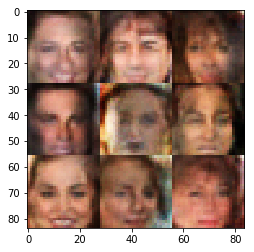

Epoch 1/1... Discriminator Loss: 1.6782... Generator Loss: 0.3905
Epoch 1/1... Discriminator Loss: 1.5777... Generator Loss: 0.4339
Epoch 1/1... Discriminator Loss: 1.2379... Generator Loss: 0.7541
Epoch 1/1... Discriminator Loss: 1.8360... Generator Loss: 0.3291
Epoch 1/1... Discriminator Loss: 1.2558... Generator Loss: 0.7457
Epoch 1/1... Discriminator Loss: 1.6767... Generator Loss: 0.4054
Epoch 1/1... Discriminator Loss: 1.6902... Generator Loss: 0.5059
Epoch 1/1... Discriminator Loss: 1.3109... Generator Loss: 0.8042
Epoch 1/1... Discriminator Loss: 1.5767... Generator Loss: 0.4447
Epoch 1/1... Discriminator Loss: 1.8065... Generator Loss: 0.3324
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


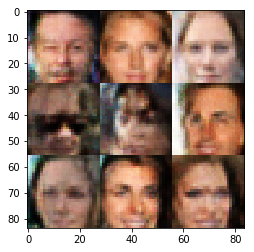

Epoch 1/1... Discriminator Loss: 1.2174... Generator Loss: 0.7092
Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 0.5520
Epoch 1/1... Discriminator Loss: 1.6654... Generator Loss: 0.3754
Epoch 1/1... Discriminator Loss: 1.5926... Generator Loss: 0.4703
Epoch 1/1... Discriminator Loss: 1.1746... Generator Loss: 0.8190
Epoch 1/1... Discriminator Loss: 1.5090... Generator Loss: 0.4705
Epoch 1/1... Discriminator Loss: 1.6414... Generator Loss: 0.3806
Epoch 1/1... Discriminator Loss: 1.4959... Generator Loss: 0.6206
Epoch 1/1... Discriminator Loss: 1.4644... Generator Loss: 0.5466
Epoch 1/1... Discriminator Loss: 1.9351... Generator Loss: 0.2701
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


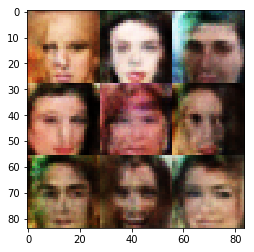

Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.5087
Epoch 1/1... Discriminator Loss: 1.5179... Generator Loss: 0.5757
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.6587
Epoch 1/1... Discriminator Loss: 1.5510... Generator Loss: 0.5245
Epoch 1/1... Discriminator Loss: 1.6074... Generator Loss: 0.4423
Epoch 1/1... Discriminator Loss: 1.0948... Generator Loss: 1.6888
Epoch 1/1... Discriminator Loss: 1.4710... Generator Loss: 0.5598
Epoch 1/1... Discriminator Loss: 1.4212... Generator Loss: 0.6363
Epoch 1/1... Discriminator Loss: 1.7713... Generator Loss: 0.3548
Epoch 1/1... Discriminator Loss: 1.1216... Generator Loss: 0.8279
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


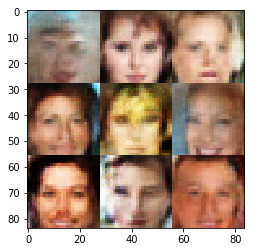

Epoch 1/1... Discriminator Loss: 1.4608... Generator Loss: 0.5052
Epoch 1/1... Discriminator Loss: 1.5003... Generator Loss: 0.6389
Epoch 1/1... Discriminator Loss: 1.9145... Generator Loss: 0.3487
Epoch 1/1... Discriminator Loss: 1.6729... Generator Loss: 0.5797
Epoch 1/1... Discriminator Loss: 1.8482... Generator Loss: 0.3139
Epoch 1/1... Discriminator Loss: 1.8956... Generator Loss: 0.2799
Epoch 1/1... Discriminator Loss: 1.5565... Generator Loss: 0.5252
Epoch 1/1... Discriminator Loss: 1.6075... Generator Loss: 0.4545
Epoch 1/1... Discriminator Loss: 1.7132... Generator Loss: 0.4466
Epoch 1/1... Discriminator Loss: 1.5441... Generator Loss: 0.4709
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


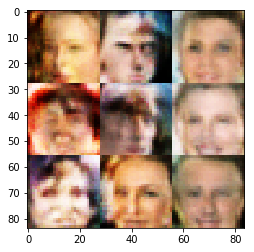

Epoch 1/1... Discriminator Loss: 1.3053... Generator Loss: 0.5559
Epoch 1/1... Discriminator Loss: 1.7416... Generator Loss: 0.4389
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.5972
Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.5889
Epoch 1/1... Discriminator Loss: 1.1285... Generator Loss: 0.8082
Epoch 1/1... Discriminator Loss: 1.6893... Generator Loss: 0.5206
Epoch 1/1... Discriminator Loss: 1.4414... Generator Loss: 0.5974
Epoch 1/1... Discriminator Loss: 1.5945... Generator Loss: 0.5059
Epoch 1/1... Discriminator Loss: 1.4989... Generator Loss: 0.4832
Epoch 1/1... Discriminator Loss: 1.7213... Generator Loss: 0.4259
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


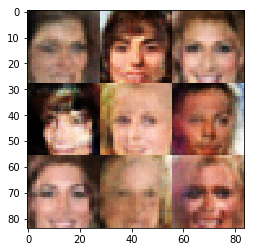

Epoch 1/1... Discriminator Loss: 1.4812... Generator Loss: 0.5181
Epoch 1/1... Discriminator Loss: 1.5618... Generator Loss: 0.5261
Epoch 1/1... Discriminator Loss: 1.6872... Generator Loss: 0.3688
Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 0.6342
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.5998
Epoch 1/1... Discriminator Loss: 1.5236... Generator Loss: 0.5142
Epoch 1/1... Discriminator Loss: 1.5315... Generator Loss: 0.4452
Epoch 1/1... Discriminator Loss: 1.8603... Generator Loss: 0.3240
Epoch 1/1... Discriminator Loss: 1.3760... Generator Loss: 0.7234
Epoch 1/1... Discriminator Loss: 1.2221... Generator Loss: 0.8175
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


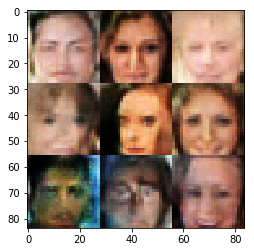

Epoch 1/1... Discriminator Loss: 1.5461... Generator Loss: 0.4794
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.5753
Epoch 1/1... Discriminator Loss: 1.3167... Generator Loss: 0.5755
Epoch 1/1... Discriminator Loss: 1.6222... Generator Loss: 0.4961
Epoch 1/1... Discriminator Loss: 1.6984... Generator Loss: 0.5046
Epoch 1/1... Discriminator Loss: 1.5971... Generator Loss: 0.4407
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.6003
Epoch 1/1... Discriminator Loss: 1.6539... Generator Loss: 0.4081
Epoch 1/1... Discriminator Loss: 1.7236... Generator Loss: 0.4482
Epoch 1/1... Discriminator Loss: 1.5053... Generator Loss: 0.4795
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


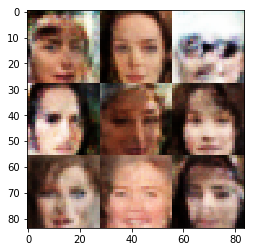

Epoch 1/1... Discriminator Loss: 1.5932... Generator Loss: 0.4225
Epoch 1/1... Discriminator Loss: 1.5872... Generator Loss: 0.4287
Epoch 1/1... Discriminator Loss: 1.8901... Generator Loss: 0.3751
Epoch 1/1... Discriminator Loss: 1.8373... Generator Loss: 0.3159
Epoch 1/1... Discriminator Loss: 1.8000... Generator Loss: 0.3450
Epoch 1/1... Discriminator Loss: 1.8104... Generator Loss: 0.3443
Epoch 1/1... Discriminator Loss: 1.7235... Generator Loss: 0.3594
Epoch 1/1... Discriminator Loss: 1.3061... Generator Loss: 0.6351
Epoch 1/1... Discriminator Loss: 1.5137... Generator Loss: 0.6684
Epoch 1/1... Discriminator Loss: 1.5213... Generator Loss: 0.5455
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


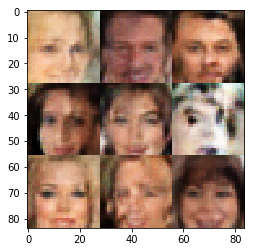

Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.6106
Epoch 1/1... Discriminator Loss: 1.5892... Generator Loss: 0.5201
Epoch 1/1... Discriminator Loss: 1.0949... Generator Loss: 1.0949
Epoch 1/1... Discriminator Loss: 1.6982... Generator Loss: 0.3975
Epoch 1/1... Discriminator Loss: 1.3745... Generator Loss: 0.5350
Epoch 1/1... Discriminator Loss: 1.6614... Generator Loss: 0.4013
Epoch 1/1... Discriminator Loss: 1.6973... Generator Loss: 0.3741
Epoch 1/1... Discriminator Loss: 1.5339... Generator Loss: 0.5077
Epoch 1/1... Discriminator Loss: 1.4744... Generator Loss: 0.6074
Epoch 1/1... Discriminator Loss: 1.4955... Generator Loss: 0.6507
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


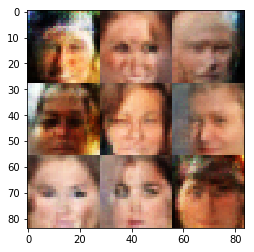

Epoch 1/1... Discriminator Loss: 1.4611... Generator Loss: 0.5981
Epoch 1/1... Discriminator Loss: 1.4607... Generator Loss: 0.5892
Epoch 1/1... Discriminator Loss: 1.5685... Generator Loss: 0.4743
Epoch 1/1... Discriminator Loss: 1.7006... Generator Loss: 0.3748
Epoch 1/1... Discriminator Loss: 1.6014... Generator Loss: 0.4317
Epoch 1/1... Discriminator Loss: 1.3433... Generator Loss: 0.7780
Epoch 1/1... Discriminator Loss: 1.5244... Generator Loss: 0.4957
Epoch 1/1... Discriminator Loss: 1.5773... Generator Loss: 0.4238
Epoch 1/1... Discriminator Loss: 1.7415... Generator Loss: 0.3884
Epoch 1/1... Discriminator Loss: 1.2020... Generator Loss: 0.8443
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


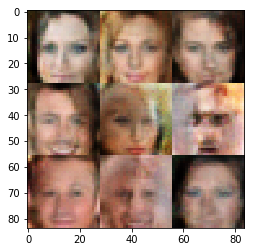

Epoch 1/1... Discriminator Loss: 1.4788... Generator Loss: 0.4893
Epoch 1/1... Discriminator Loss: 1.5096... Generator Loss: 0.5085
Epoch 1/1... Discriminator Loss: 1.5431... Generator Loss: 0.5108
Epoch 1/1... Discriminator Loss: 1.4775... Generator Loss: 0.6314
Epoch 1/1... Discriminator Loss: 1.4826... Generator Loss: 0.5417
Epoch 1/1... Discriminator Loss: 1.2998... Generator Loss: 0.5794
Epoch 1/1... Discriminator Loss: 1.2796... Generator Loss: 0.6664
Epoch 1/1... Discriminator Loss: 1.1453... Generator Loss: 0.7944
Epoch 1/1... Discriminator Loss: 1.0658... Generator Loss: 0.8962
Epoch 1/1... Discriminator Loss: 1.4824... Generator Loss: 0.5212
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


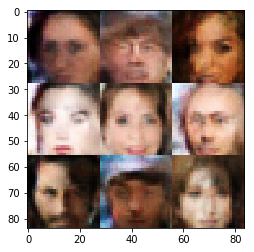

Epoch 1/1... Discriminator Loss: 1.2208... Generator Loss: 0.6657
Epoch 1/1... Discriminator Loss: 1.5996... Generator Loss: 0.5040
Epoch 1/1... Discriminator Loss: 1.4771... Generator Loss: 0.4509
Epoch 1/1... Discriminator Loss: 1.6060... Generator Loss: 0.7458
Epoch 1/1... Discriminator Loss: 1.6749... Generator Loss: 0.3547
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.5217
Epoch 1/1... Discriminator Loss: 2.0476... Generator Loss: 0.2345
Epoch 1/1... Discriminator Loss: 1.8019... Generator Loss: 0.3081
Epoch 1/1... Discriminator Loss: 1.7848... Generator Loss: 0.3356
Epoch 1/1... Discriminator Loss: 1.8475... Generator Loss: 0.3024
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


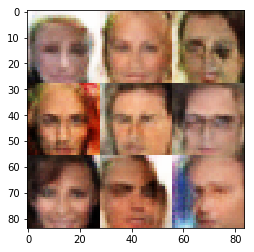

Epoch 1/1... Discriminator Loss: 1.2273... Generator Loss: 0.7346
Epoch 1/1... Discriminator Loss: 1.4879... Generator Loss: 0.4981
Epoch 1/1... Discriminator Loss: 1.0717... Generator Loss: 0.9295
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.6064
Epoch 1/1... Discriminator Loss: 1.5328... Generator Loss: 0.5425
Epoch 1/1... Discriminator Loss: 1.0961... Generator Loss: 0.8540
Epoch 1/1... Discriminator Loss: 1.6111... Generator Loss: 0.4430
Epoch 1/1... Discriminator Loss: 1.2129... Generator Loss: 0.7439
Epoch 1/1... Discriminator Loss: 1.5884... Generator Loss: 0.4513
Epoch 1/1... Discriminator Loss: 1.1128... Generator Loss: 0.8892
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


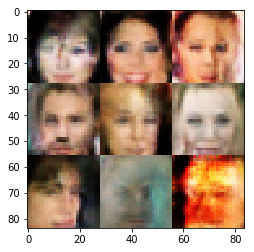

Epoch 1/1... Discriminator Loss: 1.5298... Generator Loss: 0.5736
Epoch 1/1... Discriminator Loss: 1.8945... Generator Loss: 0.2979
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.7058
Epoch 1/1... Discriminator Loss: 1.9603... Generator Loss: 0.3238
Epoch 1/1... Discriminator Loss: 1.5461... Generator Loss: 0.4606
Epoch 1/1... Discriminator Loss: 1.5926... Generator Loss: 0.4959
Epoch 1/1... Discriminator Loss: 1.6732... Generator Loss: 0.3708
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.6901
Epoch 1/1... Discriminator Loss: 1.8258... Generator Loss: 0.3923
Epoch 1/1... Discriminator Loss: 1.3206... Generator Loss: 0.5944
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


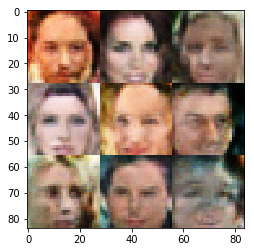

Epoch 1/1... Discriminator Loss: 1.4783... Generator Loss: 0.6542
Epoch 1/1... Discriminator Loss: 1.4955... Generator Loss: 0.6096
Epoch 1/1... Discriminator Loss: 1.7117... Generator Loss: 0.4906
Epoch 1/1... Discriminator Loss: 1.6979... Generator Loss: 0.4304
Epoch 1/1... Discriminator Loss: 1.5457... Generator Loss: 0.4366
Epoch 1/1... Discriminator Loss: 1.5424... Generator Loss: 0.5180
Epoch 1/1... Discriminator Loss: 1.6068... Generator Loss: 0.5003
Epoch 1/1... Discriminator Loss: 1.7222... Generator Loss: 0.3751
Epoch 1/1... Discriminator Loss: 1.8278... Generator Loss: 0.4014
Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 0.5497
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


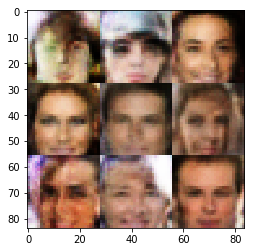

Epoch 1/1... Discriminator Loss: 2.0148... Generator Loss: 0.2662
Epoch 1/1... Discriminator Loss: 1.7904... Generator Loss: 0.3125
Epoch 1/1... Discriminator Loss: 1.5303... Generator Loss: 0.6793
Epoch 1/1... Discriminator Loss: 1.4695... Generator Loss: 0.5713
Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.5309
Epoch 1/1... Discriminator Loss: 2.1080... Generator Loss: 0.2697
Epoch 1/1... Discriminator Loss: 1.8477... Generator Loss: 0.3072
Epoch 1/1... Discriminator Loss: 2.3312... Generator Loss: 0.2815
Epoch 1/1... Discriminator Loss: 1.5796... Generator Loss: 0.5078
Epoch 1/1... Discriminator Loss: 1.9872... Generator Loss: 0.2797
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


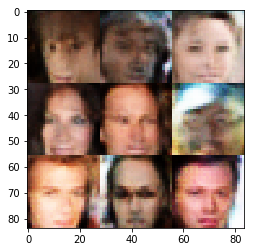

Epoch 1/1... Discriminator Loss: 2.0288... Generator Loss: 0.2859
Epoch 1/1... Discriminator Loss: 1.5986... Generator Loss: 0.4382
Epoch 1/1... Discriminator Loss: 1.2529... Generator Loss: 0.6920
Epoch 1/1... Discriminator Loss: 1.5031... Generator Loss: 0.5729
Epoch 1/1... Discriminator Loss: 1.4976... Generator Loss: 0.6246
Epoch 1/1... Discriminator Loss: 1.5267... Generator Loss: 0.5710
Epoch 1/1... Discriminator Loss: 1.4865... Generator Loss: 0.5936
Epoch 1/1... Discriminator Loss: 2.0540... Generator Loss: 0.2845
Epoch 1/1... Discriminator Loss: 1.5512... Generator Loss: 0.4540
Epoch 1/1... Discriminator Loss: 1.5422... Generator Loss: 0.4187
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


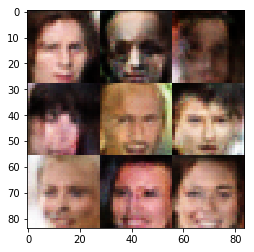

Epoch 1/1... Discriminator Loss: 1.1243... Generator Loss: 0.7977
Epoch 1/1... Discriminator Loss: 1.4880... Generator Loss: 0.5156
Epoch 1/1... Discriminator Loss: 1.4382... Generator Loss: 0.5352
Epoch 1/1... Discriminator Loss: 1.6121... Generator Loss: 0.4608
Epoch 1/1... Discriminator Loss: 1.9354... Generator Loss: 0.2942
Epoch 1/1... Discriminator Loss: 1.6082... Generator Loss: 0.4900
Epoch 1/1... Discriminator Loss: 1.2000... Generator Loss: 0.7515
Epoch 1/1... Discriminator Loss: 1.5002... Generator Loss: 0.4795
Epoch 1/1... Discriminator Loss: 1.3132... Generator Loss: 0.7129
Epoch 1/1... Discriminator Loss: 1.6391... Generator Loss: 0.4194
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


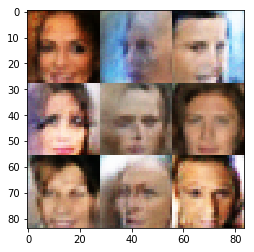

Epoch 1/1... Discriminator Loss: 1.7539... Generator Loss: 0.4140
Epoch 1/1... Discriminator Loss: 2.4900... Generator Loss: 0.2056
Epoch 1/1... Discriminator Loss: 1.5750... Generator Loss: 0.5436
Epoch 1/1... Discriminator Loss: 1.8870... Generator Loss: 0.2986
Epoch 1/1... Discriminator Loss: 1.6327... Generator Loss: 0.4254
Epoch 1/1... Discriminator Loss: 1.4828... Generator Loss: 0.5733
Epoch 1/1... Discriminator Loss: 1.4440... Generator Loss: 0.5299
Epoch 1/1... Discriminator Loss: 1.5441... Generator Loss: 0.4911
Epoch 1/1... Discriminator Loss: 1.4425... Generator Loss: 0.6334
Epoch 1/1... Discriminator Loss: 1.5543... Generator Loss: 0.4845
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


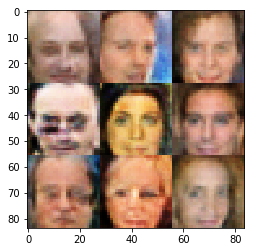

Epoch 1/1... Discriminator Loss: 1.6274... Generator Loss: 0.4695
Epoch 1/1... Discriminator Loss: 1.3423... Generator Loss: 0.6136
Epoch 1/1... Discriminator Loss: 1.2695... Generator Loss: 0.6097
Epoch 1/1... Discriminator Loss: 1.3642... Generator Loss: 0.6024
Epoch 1/1... Discriminator Loss: 1.8114... Generator Loss: 0.3372
Epoch 1/1... Discriminator Loss: 1.5520... Generator Loss: 0.5142
Epoch 1/1... Discriminator Loss: 1.7034... Generator Loss: 0.3818
Epoch 1/1... Discriminator Loss: 1.4681... Generator Loss: 0.4835
Epoch 1/1... Discriminator Loss: 1.6880... Generator Loss: 0.4871
Epoch 1/1... Discriminator Loss: 1.5764... Generator Loss: 0.5143
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


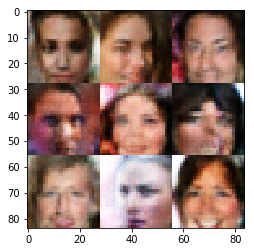

Epoch 1/1... Discriminator Loss: 1.6276... Generator Loss: 0.4700
Epoch 1/1... Discriminator Loss: 1.5486... Generator Loss: 0.5722
Epoch 1/1... Discriminator Loss: 1.5114... Generator Loss: 0.5313
Epoch 1/1... Discriminator Loss: 1.3084... Generator Loss: 0.6221
Epoch 1/1... Discriminator Loss: 1.5770... Generator Loss: 0.4407
Epoch 1/1... Discriminator Loss: 1.5876... Generator Loss: 0.4368
Epoch 1/1... Discriminator Loss: 1.5600... Generator Loss: 0.4126
Epoch 1/1... Discriminator Loss: 1.5363... Generator Loss: 0.4716
Epoch 1/1... Discriminator Loss: 1.4240... Generator Loss: 0.5555
Epoch 1/1... Discriminator Loss: 1.3599... Generator Loss: 0.6543
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


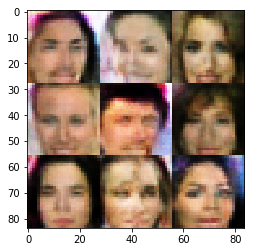

Epoch 1/1... Discriminator Loss: 1.6173... Generator Loss: 0.5179
Epoch 1/1... Discriminator Loss: 1.9140... Generator Loss: 0.2762
Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.6032
Epoch 1/1... Discriminator Loss: 1.5350... Generator Loss: 0.5645
Epoch 1/1... Discriminator Loss: 1.1976... Generator Loss: 0.7007
Epoch 1/1... Discriminator Loss: 1.2899... Generator Loss: 0.6194
Epoch 1/1... Discriminator Loss: 1.3279... Generator Loss: 0.6765
Epoch 1/1... Discriminator Loss: 1.7391... Generator Loss: 0.3457
Epoch 1/1... Discriminator Loss: 1.3018... Generator Loss: 0.7284
Epoch 1/1... Discriminator Loss: 1.6809... Generator Loss: 0.3958
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


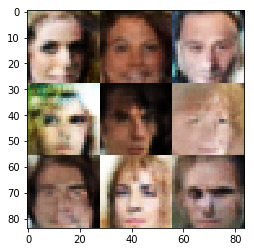

Epoch 1/1... Discriminator Loss: 1.2524... Generator Loss: 0.8406
Epoch 1/1... Discriminator Loss: 1.4487... Generator Loss: 0.6037
Epoch 1/1... Discriminator Loss: 1.7641... Generator Loss: 0.4027
Epoch 1/1... Discriminator Loss: 1.3501... Generator Loss: 0.6599
Epoch 1/1... Discriminator Loss: 1.2660... Generator Loss: 0.6323
Epoch 1/1... Discriminator Loss: 1.7153... Generator Loss: 0.3461
Epoch 1/1... Discriminator Loss: 1.4722... Generator Loss: 0.5849
Epoch 1/1... Discriminator Loss: 1.3298... Generator Loss: 0.6034
Epoch 1/1... Discriminator Loss: 1.8195... Generator Loss: 0.3414
Epoch 1/1... Discriminator Loss: 1.5758... Generator Loss: 0.4133
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


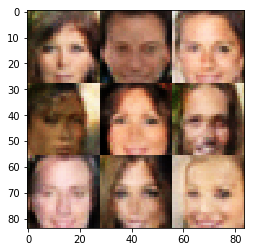

Epoch 1/1... Discriminator Loss: 1.5973... Generator Loss: 0.5343
Epoch 1/1... Discriminator Loss: 0.9890... Generator Loss: 1.1685
Epoch 1/1... Discriminator Loss: 1.3631... Generator Loss: 0.8107
Epoch 1/1... Discriminator Loss: 1.9428... Generator Loss: 0.2898
Epoch 1/1... Discriminator Loss: 1.8592... Generator Loss: 0.3225
Epoch 1/1... Discriminator Loss: 1.6404... Generator Loss: 0.3916
Epoch 1/1... Discriminator Loss: 1.6833... Generator Loss: 0.5138
Epoch 1/1... Discriminator Loss: 1.3015... Generator Loss: 0.7865
Epoch 1/1... Discriminator Loss: 1.4602... Generator Loss: 0.4766
Epoch 1/1... Discriminator Loss: 2.0326... Generator Loss: 0.2627
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


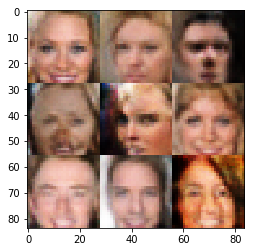

Epoch 1/1... Discriminator Loss: 1.5956... Generator Loss: 0.5592
Epoch 1/1... Discriminator Loss: 1.3131... Generator Loss: 0.5971
Epoch 1/1... Discriminator Loss: 1.6651... Generator Loss: 0.4093
Epoch 1/1... Discriminator Loss: 1.6980... Generator Loss: 0.3415
Epoch 1/1... Discriminator Loss: 1.3485... Generator Loss: 0.5521
Epoch 1/1... Discriminator Loss: 1.0342... Generator Loss: 0.9230
Epoch 1/1... Discriminator Loss: 1.6585... Generator Loss: 0.4263
Epoch 1/1... Discriminator Loss: 1.2070... Generator Loss: 0.7598
Epoch 1/1... Discriminator Loss: 1.9724... Generator Loss: 0.2774
Epoch 1/1... Discriminator Loss: 1.4599... Generator Loss: 0.5867
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


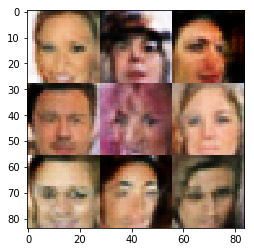

Epoch 1/1... Discriminator Loss: 0.9531... Generator Loss: 1.8913
Epoch 1/1... Discriminator Loss: 1.1922... Generator Loss: 0.7650
Epoch 1/1... Discriminator Loss: 1.8414... Generator Loss: 0.3107
Epoch 1/1... Discriminator Loss: 1.9165... Generator Loss: 0.2787
Epoch 1/1... Discriminator Loss: 1.5408... Generator Loss: 0.5452
Epoch 1/1... Discriminator Loss: 1.3552... Generator Loss: 0.6606
Epoch 1/1... Discriminator Loss: 1.7327... Generator Loss: 0.4013
Epoch 1/1... Discriminator Loss: 1.7585... Generator Loss: 0.3535
Epoch 1/1... Discriminator Loss: 1.6345... Generator Loss: 0.4035
Epoch 1/1... Discriminator Loss: 1.7543... Generator Loss: 0.4179
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


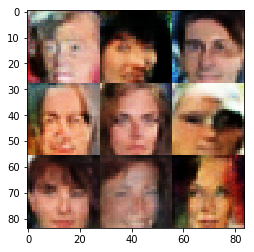

Epoch 1/1... Discriminator Loss: 1.5530... Generator Loss: 0.4830
Epoch 1/1... Discriminator Loss: 1.5935... Generator Loss: 0.4920
Epoch 1/1... Discriminator Loss: 1.5236... Generator Loss: 0.5786
Epoch 1/1... Discriminator Loss: 1.5654... Generator Loss: 0.4625
Epoch 1/1... Discriminator Loss: 1.4431... Generator Loss: 0.7068
Epoch 1/1... Discriminator Loss: 1.7773... Generator Loss: 0.3837
Epoch 1/1... Discriminator Loss: 1.6303... Generator Loss: 0.4474
Epoch 1/1... Discriminator Loss: 1.5841... Generator Loss: 0.5071
Epoch 1/1... Discriminator Loss: 1.3155... Generator Loss: 0.8125
Epoch 1/1... Discriminator Loss: 1.6177... Generator Loss: 0.5797
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


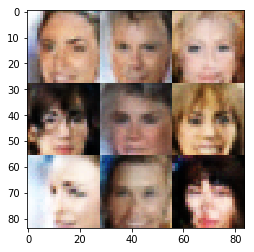

Epoch 1/1... Discriminator Loss: 1.6693... Generator Loss: 0.4343
Epoch 1/1... Discriminator Loss: 1.7296... Generator Loss: 0.3963
Epoch 1/1... Discriminator Loss: 1.5316... Generator Loss: 0.4715
Epoch 1/1... Discriminator Loss: 1.7377... Generator Loss: 0.3778
Epoch 1/1... Discriminator Loss: 1.0422... Generator Loss: 1.0024
Epoch 1/1... Discriminator Loss: 1.4642... Generator Loss: 0.5878
Epoch 1/1... Discriminator Loss: 1.8180... Generator Loss: 0.3925
Epoch 1/1... Discriminator Loss: 1.4764... Generator Loss: 0.5607
Epoch 1/1... Discriminator Loss: 1.5385... Generator Loss: 0.5042
Epoch 1/1... Discriminator Loss: 1.5971... Generator Loss: 0.4940
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


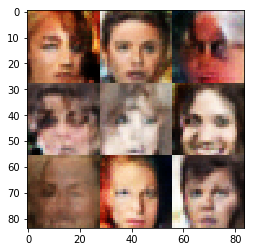

Epoch 1/1... Discriminator Loss: 1.3064... Generator Loss: 0.7070
Epoch 1/1... Discriminator Loss: 1.5843... Generator Loss: 0.5077
Epoch 1/1... Discriminator Loss: 1.5979... Generator Loss: 0.4620
Epoch 1/1... Discriminator Loss: 1.2520... Generator Loss: 0.7049
Epoch 1/1... Discriminator Loss: 1.2642... Generator Loss: 0.7335
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.5845
Epoch 1/1... Discriminator Loss: 1.1470... Generator Loss: 0.8761
Epoch 1/1... Discriminator Loss: 1.6779... Generator Loss: 0.4539
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.5829
Epoch 1/1... Discriminator Loss: 1.4852... Generator Loss: 0.5482
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


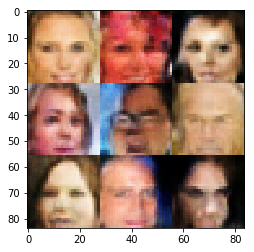

Epoch 1/1... Discriminator Loss: 1.4456... Generator Loss: 0.6222
Epoch 1/1... Discriminator Loss: 1.5728... Generator Loss: 0.4731
Epoch 1/1... Discriminator Loss: 1.7120... Generator Loss: 0.3885
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 0.5554
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.8151
Epoch 1/1... Discriminator Loss: 1.5455... Generator Loss: 0.5135
Epoch 1/1... Discriminator Loss: 1.5965... Generator Loss: 0.4553
Epoch 1/1... Discriminator Loss: 1.1484... Generator Loss: 0.9104
Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 0.5189
Epoch 1/1... Discriminator Loss: 1.7577... Generator Loss: 0.3663
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


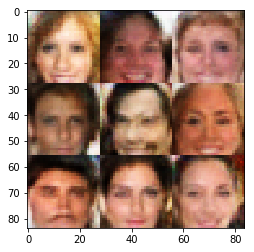

Epoch 1/1... Discriminator Loss: 1.4680... Generator Loss: 0.4735
Epoch 1/1... Discriminator Loss: 1.7715... Generator Loss: 0.4019
Epoch 1/1... Discriminator Loss: 1.5551... Generator Loss: 0.4358
Epoch 1/1... Discriminator Loss: 1.8048... Generator Loss: 0.4342
Epoch 1/1... Discriminator Loss: 1.5411... Generator Loss: 0.5132
Epoch 1/1... Discriminator Loss: 1.5567... Generator Loss: 0.4719
Epoch 1/1... Discriminator Loss: 1.7021... Generator Loss: 0.4143
Epoch 1/1... Discriminator Loss: 1.6625... Generator Loss: 0.3724
Epoch 1/1... Discriminator Loss: 1.6265... Generator Loss: 0.4992
Epoch 1/1... Discriminator Loss: 1.6178... Generator Loss: 0.5283
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


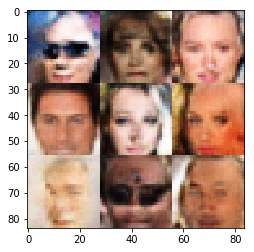

Epoch 1/1... Discriminator Loss: 1.3183... Generator Loss: 0.6827
Epoch 1/1... Discriminator Loss: 1.4384... Generator Loss: 0.5372
Epoch 1/1... Discriminator Loss: 1.6313... Generator Loss: 0.4549
Epoch 1/1... Discriminator Loss: 1.5726... Generator Loss: 0.4810
Epoch 1/1... Discriminator Loss: 1.1788... Generator Loss: 0.7282
Epoch 1/1... Discriminator Loss: 1.5557... Generator Loss: 0.4508
Epoch 1/1... Discriminator Loss: 1.6929... Generator Loss: 0.4306
Epoch 1/1... Discriminator Loss: 1.5207... Generator Loss: 0.5854
Epoch 1/1... Discriminator Loss: 1.4779... Generator Loss: 0.5667
Epoch 1/1... Discriminator Loss: 1.4677... Generator Loss: 0.5471
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


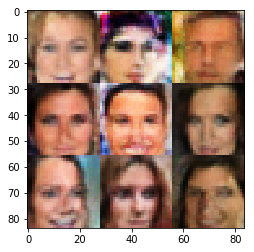

Epoch 1/1... Discriminator Loss: 1.5597... Generator Loss: 0.4665
Epoch 1/1... Discriminator Loss: 1.8458... Generator Loss: 0.3856
Epoch 1/1... Discriminator Loss: 1.5277... Generator Loss: 0.4912
Done
(?, 7, 7, 512)
(?, 14, 14, 256)
(?, 28, 28, 128)
(?, 28, 28, 64)
(?, 28, 28, 3)


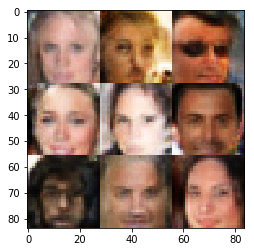

In [43]:
batch_size = 32
z_dim = 200
learning_rate = 0.0001
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.